In [4]:
!nvidia-smi

Mon Mar 31 16:19:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 🔵 **Dependencies**

In [ ]:
!pip install -q transformers datasets

In [5]:
!pip install -q torch==2.2.0 torchvision==0.17.0 torchaudio==2.2.0 torchtext==0.17.0 --index-url https://download.pytorch.org/whl/cu121

In [3]:
!pip install -q numpy==2.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 85.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.0 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.0 which is incompatible.


# 🔵 **Import Libraries**

In [92]:
from datasets import load_dataset
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import seaborn as sns

In [93]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 🔵 **TinyStories Dataset**

## 🔵 **LoadDataset**

In [3]:
dataset = load_dataset("roneneldan/TinyStories")
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2119719
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 21990
    })
})

In [4]:
train_dataset = dataset['train']
valid_dataset = dataset['validation']
print('Number of train rows(stories): ', train_dataset.num_rows/1e6, 'Million rows(stories)')
print('Number of valid rows(stories): ', valid_dataset.num_rows/1e6, 'Million rows(stories)')

Number of train rows(stories):  2.119719 Million rows(stories)
Number of valid rows(stories):  0.02199 Million rows(stories)


## 🔵 **EDA(Exploratory Data Analysis)**

In [5]:
tokenizer = get_tokenizer('basic_english')

In [16]:
num_tok = 0
num_char = 0
token_counts = Counter()
batch = 512
dataset_size = len(train_dataset['text'])

with tqdm(range(dataset_size // batch + 1)) as tep:
    for i in tep:
        batch_texts = train_dataset[i * batch : (i + 1) * batch]['text']
        text = " ".join(batch_texts)
        num_char += len(text)
        tokenized = tokenizer(text)
        num_tok += len(tokenized)
        token_counts.update(tokenized)

        tep.set_postfix(unique_tokens=len(token_counts), number_of_tokens=num_tok, number_of_characters=num_char)

100%|██████████| 4141/4141 [05:23<00:00, 12.80it/s, number_of_characters=1.9e+9, number_of_tokens=4.39e+8, unique_tokens=63577]


In [29]:
df_count = pd.DataFrame.from_dict(token_counts, orient='index', columns=['count'])

In [71]:
print('Number of characters in train part: ', num_char/1e9, 'Billion characters')
print('Number of tokens in train part: ', num_tok/1e6, 'Million tokens')
print('Number of unique tokens in train part: ', len(token_counts), 'tokens')
print(f'On average, there are {num_char//dataset_size} characters in each story.: ')
print(f'On average, there are {num_tok//dataset_size} tokens in each story.')
print(f"The most common token is '{df_count[df_count['count'] == df_count['count'].values.max()].index.tolist()[0]}' \
with {df_count['count'].values.max()/1e6} million occurrences.")
des = df_count.describe()
print(f"The mean token repetition count is {int(des['count']['mean'])}.")
print(f"The standard deviation of token repetition is {int(des['count']['std'])}.")
print(f"The minimum token repetition count is {int(des['count']['min'])}.")
print(f"The 25th percentile of token repetition is {int(des['count']['25%'])}.")
print(f"The median token repetition count is {int(des['count']['50%'])}.")
print(f"The 75th percentile of token repetition is {int(des['count']['75%'])}.")
print(f"The maximum token repetition count is {int(des['count']['max'])}.")


print("\n\033[1m" + "📊 Text Dataset Statistics" + "\033[0m" + "\n" + "-"*50)
print(f"\033[1m• Characters:\033[0m {num_char/1e9:.2f} Billion")
print(f"\033[1m• Tokens:\033[0m {num_tok/1e6:.2f} Million")
print(f"\033[1m• Unique Tokens:\033[0m {len(token_counts):,}")
print("\n\033[1m📝 Per-Story Averages:\033[0m")
print(f"  → Characters: {num_char//dataset_size:,}")
print(f"  → Tokens: {num_tok//dataset_size:,}")
most_common_token = df_count[df_count['count'] == df_count['count'].max()].index[0]
print(f"\n\033[1m🏆 Most Frequent Token:\033[0m")
print(f"  → '{most_common_token}' ({df_count['count'].max()/1e6:.2f} million occurrences)")
print("\n\033[1m📈 Token Repetition Statistics:\033[0m")
print(f"  → Mean: {int(des['count']['mean'])}")
print(f"  → Std Dev: {int(des['count']['std']):,}")
print(f"  → Min: {int(des['count']['min']):,}")
print(f"  → 25th Percentile: {int(des['count']['25%']):,}")
print(f"  → Median: {int(des['count']['50%']):,}")
print(f"  → 75th Percentile: {int(des['count']['75%']):,}")
print(f"  → Max: {int(des['count']['max']):,}")
print("-"*50)

Number of characters in train part:  1.902088781 Billion characters
Number of tokens in train part:  439.039906 Million tokens
Number of unique tokens in train part:  63577 tokens
On average, there are 897 characters in each story.: 
On average, there are 207 tokens in each story.
The most common token is '.' with 36.459483 million occurrences.
The mean token repetition count is 6905.
The standard deviation of token repetition is 226804.
The minimum token repetition count is 1.
The 25th percentile of token repetition is 1.
The median token repetition count is 3.
The 75th percentile of token repetition is 24.
The maximum token repetition count is 36459483.

📊 Text Dataset Statistics
--------------------------------------------------
• Characters: 1.90 Billion
• Tokens: 439.04 Million
• Unique Tokens: 63,577

📝 Per-Story Averages:
  → Characters: 897
  → Tokens: 207

🏆 Most Frequent Token:
  → '.' (36.46 million occurrences)

📈 Token Repetition Statistics:
  → Mean: 6905
  → Std Dev: 226

**
🔝 Top 10 Tokens**

,count
.,"36,459,483"
the,"20,239,799"
and,"18,112,895"
",","17,359,980"
to,"12,648,384"
a,"11,475,893"
was,"9,436,658"
he,"7,977,807"
she,"7,710,551"
it,"7,104,640"


<Figure size 1200x600 with 0 Axes>

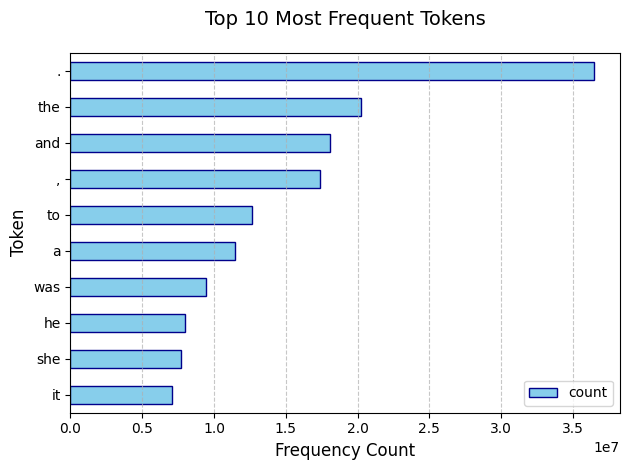

In [74]:
print_bold("\n🔝 Top 10 Tokens")
top_10 = df_count.sort_values('count', ascending=False).head(10)
display(top_10.style.format({'count': '{:,}'}).background_gradient(cmap='Blues'))

plt.figure(figsize=(12, 6))
top_10.plot(kind='barh', color='skyblue', edgecolor='darkblue')
plt.title('Top 10 Most Frequent Tokens', fontsize=14, pad=20)
plt.xlabel('Frequency Count', fontsize=12)
plt.ylabel('Token', fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

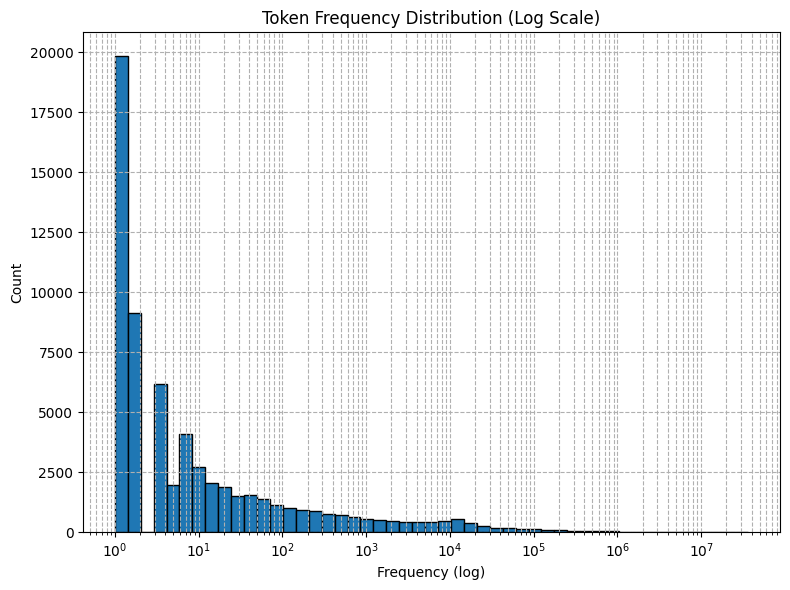

In [91]:
def gini_coefficient(array):
    array = np.array(array, dtype=np.float64)
    if np.any(array < 0):
        array -= np.amin(array)
    array += np.finfo(float).eps
    array = np.sort(array)
    n = len(array)
    index = np.arange(1, n+1)
    return float((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)))


plt.figure(figsize=(8, 6))
if len(df_count) > 0:
    bins = np.logspace(np.log10(df_count['count'].min()),
                     np.log10(df_count['count'].max()),
                     50)
    plt.hist(df_count['count'], bins=bins, edgecolor='black')
    plt.xscale('log')
    plt.title('Token Frequency Distribution (Log Scale)')
    plt.xlabel('Frequency (log)')
    plt.ylabel('Count')
    plt.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()